# Predicting United States Real Estate Prices
By: Grace Li, Olivia Weisiger and Fionnuala Eastwood

### Outline
1. Dataset Preprocessing and Merging
2. Data Visualization
3. Classic Machine Learning Models
4. Deep Learning Models
5. Analysis of accuracy and results

### Context
The United States housing market is...

### Our Goal

This project will explore the current United States real-estate market, investigate what factors influence the price of property, and create multiple machine learning models that predict these housing costs throughout the country. More specifically, this will be accomplished through implementation of (add briefly about what models we end up using....) Being able to infer and understand the trends of real estate is extremely valuable economic knowledge that will provide important insights about our country. 

Furthermore, our project aims to deepen our understanding of how societal biases influence external structures such as the economy. By merging datasets, we will investigate which underlying factors such as (add briefly when choose other data) affect the prices of houses in order to draw deeper conclusions about intangible factors impacting our economic climate.

### Import Packages and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

This data is from Kaggle's "USA Real Estate Dataset" found here: https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset

In [3]:
df = pd.read_csv('realtor-data.zip.csv')

### Initial Data Processing
Let's first break down what our dataset looks like...

In [4]:
df.shape

(2226382, 12)

We have a dataset with over 2 million rows and 12 columns. Since this is way too many samples to process in a reasonable computational time, we will take a random subset of 100,000 of these samples to perform analysis on.

In [5]:
random.seed(10)
df = df.sample(50000)
print(df.shape)

(50000, 12)


With our refined sample, let's get an idea of what our dataset looks like by outputting a few rows of the table.

In [6]:
df.head()

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
1829353,31344.0,sold,300000.0,3.0,2.0,0.32,1728557.0,New Hope,Minnesota,55427.0,2990.0,2022-03-08
1643751,6916.0,sold,1295000.0,4.0,4.0,0.20,246711.0,Atlanta,Georgia,30306.0,2543.0,2022-04-04
566334,25789.0,for_sale,731970.0,4.0,3.0,0.19,470944.0,Bradenton,Florida,34211.0,2537.0,NaN
616655,92089.0,for_sale,94000.0,NaN,NaN,10.40,1880375.0,Gainesboro,Tennessee,38562.0,NaN,NaN
754326,30253.0,for_sale,140000.0,2.0,1.0,0.14,1624264.0,Jackson,Michigan,49202.0,931.0,2013-12-17


Notice that each sample in the dataset is a real estate listing in the United States (the listings are all from 2022-2024), and each sample has 12 features that provide numerical or categorical information about the listing.

Here is an overview of each feature's meaning and data type:

- brokered_by:

- status:

- price:

- bed:

- bath:

- etc fill in later (look on kaggle these descriptins are provided)

Now that we have an understanding of our data set, we will perform some processing on the data so that it is cleaner to use. Firstly, we will drop some unnecessary columns that do not contribute to our analysis goals. The brokered_by column which encodes the real-estate company in charge of the property is not necessary because we are interested in the qualities of the house itself. Additionally, the status column is not needed because we will use the price set for the house equivalently regardless if it is sold or for sale. Lastly, the previously sold date can be dropped since we are focused on the current selling price. We will trim our dataset from 12 columns to 9 with these modifications.

In [7]:
df = df.drop(['brokered_by', 'status', 'prev_sold_date'], axis=1)

This dataset contains listings from the United States and all it's territories. For our purposes, we only want to analyze data from the 50 states (and Washington, DC) so let's trim out samples taken from Puerto Rico and the Virgin Islands.

In [8]:
df = df[(df['state'] != "Puerto Rico") & (df['state'] != "Virgin Islands")]

Our next processing step is making sure we don't have any NaN's in our dataset, as empty data values might impact our analysis models.

In [9]:
#sum up all NaN values present in dataset (in any feature column)
print (df.isnull().sum().sum())

42610


We see that we have some data entries with no value, so let's remove all rows that contain any NaN values. We will also check the shape of our data frame after this removal to make sure we still have plenty of samples to work with.

In [10]:
#remove all rows missing data
df = df.dropna()

#verify we now have no NaN values, expect a value of zero
print (f'We now have: {df.isnull().sum().sum()} NaN entires')

#print new shape
print (f'Our new dataset shape is {df.shape}')


We now have: 0 NaN entires
Our new dataset shape is (30328, 9)


We successfully dropped all empty entries and still have a substantial size data frame to analyze.

Our last step in data processing is preparing our target price data for our future machine learning models. We noticed that predicting the price to an exact number (as the current column does) is quite specific, so instead in some cases we will want to predict whether any piece of real-estate is more generally expensive or cheap. The next question that follows is how we will quantify this "expensive" vs "cheap". 

Our natural thought was just categorizing the samples based on if they were on the higher half of all in our dataset vs the lowest. However, upon further analysis we realize that the state the property is in has an overwhelmingly powerful influence on this categorization. For example we would see that practically all samples from New York would fall in the upper portion of data, while a huge majority of samples from rural states will be in the lower. This would leave our model with very little to do, so to work around this we have decided to create a categorical column that contains a 1 if the property price is above the median housing price **of the state it is in**, and a 0 if the property is below this median average of its state. This takes out the state bias and may lead to more informative conclusions about other features that are no longer overshadowed.

To do this, we first merge data with the median housing prices by state. This data was taken from the following link: https://www.bankrate.com/real-estate/median-home-price/#how-much, and is up to date as of November 2023 (which is the same time period our real-estate data was taken from).

In [11]:
#upload data
df_med = pd.read_csv('median_prices.csv')
df_med.head()

#select state and median price columns we want
df_med = df_med[["state", "med_price"]]

#merge along state column
df = pd.merge(df, df_med, on = ["state"])
df.head()

,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,med_price
0,300000.0,3.0,2.0,0.32,1728557.0,New Hope,Minnesota,55427.0,2990.0,"$330,500"
1,399000.0,4.0,2.0,2.69,559528.0,Oak Grove,Minnesota,55011.0,2400.0,"$330,500"
2,394900.0,4.0,3.0,0.24,497833.0,New Brighton,Minnesota,55112.0,2107.0,"$330,500"
3,650000.0,4.0,3.0,0.19,1542009.0,New Brighton,Minnesota,55112.0,2968.0,"$330,500"
4,419000.0,3.0,2.0,0.08,1812742.0,Plymouth,Minnesota,55447.0,1152.0,"$330,500"


Notice one more problem exists: we have a price listed in string form with dollar sign and commas. Instead we want it to be numerical in order to compare it with our current price column.

In [12]:
# Remove dollar signs and commas, then convert to integers
df['med_price'] = df['med_price'].replace({'\$': '', ',': ''}, regex=True).astype(int)

Lastly, we want to create a new column which we will call above_average. This column will contain a 1 if the price of that sample is above the median price in the state, and a 0 if it is below. We will also remove the median price column afterwards because it served its purpose.

In [13]:
df['above_average'] = df.apply(lambda row: 1 if row['price'] > row['med_price'] else 0, axis=1)
df = df.drop('med_price', axis = 1)
df.head()

,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,above_average
0,300000.0,3.0,2.0,0.32,1728557.0,New Hope,Minnesota,55427.0,2990.0,0
1,399000.0,4.0,2.0,2.69,559528.0,Oak Grove,Minnesota,55011.0,2400.0,1
2,394900.0,4.0,3.0,0.24,497833.0,New Brighton,Minnesota,55112.0,2107.0,1
3,650000.0,4.0,3.0,0.19,1542009.0,New Brighton,Minnesota,55112.0,2968.0,1
4,419000.0,3.0,2.0,0.08,1812742.0,Plymouth,Minnesota,55447.0,1152.0,1


In [14]:
print(df.shape)

(30327, 10)


This looks good, now we are ready to merge with other data sets to add more features to analyze.

### Dataset Merging

While the relationship between features such as number of rooms or number of acres on real-estate prices is quite intuitive, this project aims to delve beyond these variables and investigate more abstract influences. This will be done by merging our current dataframe with new datasets in order to add features including minimum wage of the state, median income by zip code, and even political affiliation, as we are curious if any of these variables will display a strong correlation with housing prices. One caution to note is that our original real estate data is from the past two years, so we will need to make sure the data we are merging with is taken from the same time period in order to obtain accurate conclusions.

The first dataset we will merge with is Kaggle's "US Household Income by Zip Code 2021-2011" found here: https://www.kaggle.com/datasets/claygendron/us-household-income-by-zip-code-2021-2011

In [16]:
df_income = pd.read_csv('us_income_zipcode.csv')
df_income.head()

,ZIP,Geography,Geographic Area Name,Households,Households Margin of Error,"Households Less Than $10,000","Households Less Than $10,000 Margin of Error","Households $10,000 to $14,999","Households $10,000 to $14,999 Margin of Error","Households $15,000 to $24,999",...,"Nonfamily Households $150,000 to $199,999","Nonfamily Households $150,000 to $199,999 Margin of Error","Nonfamily Households $200,000 or More","Nonfamily Households $200,000 or More Margin of Error",Nonfamily Households Median Income (Dollars),Nonfamily Households Median Income (Dollars) Margin of Error,Nonfamily Households Mean Income (Dollars),Nonfamily Households Mean Income (Dollars) Margin of Error,Nonfamily Households Nonfamily Income in the Past 12 Months,Year
0,601,860Z200US00601,ZCTA5 00601,5397.0,264.0,33.2,4.4,15.7,2.9,23.9,...,0.0,2.8,0.0,2.8,9386.0,1472.0,13044.0,1949.0,15.0,2021.0
1,602,860Z200US00602,ZCTA5 00602,12858.0,448.0,27.1,2.9,12.7,2.1,20.5,...,0.0,1.3,0.0,1.3,11242.0,1993.0,16419.0,2310.0,20.1,2021.0
2,603,860Z200US00603,ZCTA5 00603,19295.0,555.0,32.1,2.5,13.4,1.6,17.2,...,0.6,0.6,0.2,0.4,10639.0,844.0,16824.0,2217.0,34.9,2021.0
3,606,860Z200US00606,ZCTA5 00606,1968.0,171.0,28.4,5.5,13.3,4.4,23.3,...,0.0,7.5,0.0,7.5,15849.0,3067.0,16312.0,2662.0,13.0,2021.0
4,610,860Z200US00610,ZCTA5 00610,8934.0,372.0,20.5,2.5,13.2,2.5,23.3,...,0.0,1.8,0.0,1.8,12832.0,2405.0,16756.0,1740.0,14.5,2021.0


This dataset contains the results of the 2011 and 2021 national census, and we have chosen it in order to add a median income feature to our real estate pricing dataset. As explained above, we are only interested in the 2021 data since our pricing data comes from recent years, so we will trim down our dataset accordingly. Additionally, the dataset comes with dozens of feature columns, but for our purposes we only need to keep the zip code column (which we will use to merge our original dataset), and the median household income column. So let's process our dataset and display the cleaner result.

In [17]:
#select only samples from most recent census
df_income = df_income[df_income["Year"] == 2021.0]

#select only features we want
df_income = df_income[["ZIP", "Nonfamily Households Median Income (Dollars)"]]

df_income.head()

,ZIP,Nonfamily Households Median Income (Dollars)
0,601,9386.0
1,602,11242.0
2,603,10639.0
3,606,15849.0
4,610,12832.0


Now we are ready to merge with our original dataset. Currently our zip code columns have different names so we will rename them identically, and they also have different types (integer vs float) so we will convert to a float variable to avoid type error interference.

In [18]:
df_income["ZIP"] = df_income["ZIP"].astype(float)

df_income = df_income.rename(columns={'ZIP': 'zip_code'})

We will use an inner merge (explain why...)
The census data was very thorough (we have very few NaN values), so we can just remove any empty data rows and our dataset remains practically the same. We verify this assumption by outputting our dataset shape after the merge.

In [19]:
df = pd.merge(df, df_income, on = ["zip_code"])

#remove all rows missing data
df = df.dropna()

print (df.shape)
df.head()

(29948, 11)


,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,above_average,Nonfamily Households Median Income (Dollars)
0,300000.0,3.0,2.0,0.32,1728557.0,New Hope,Minnesota,55427.0,2990.0,0,46403.0
1,550000.0,5.0,3.0,0.29,1723318.0,Golden Valley,Minnesota,55427.0,3137.0,1,46403.0
2,399000.0,4.0,2.0,2.69,559528.0,Oak Grove,Minnesota,55011.0,2400.0,1,69792.0
3,375000.0,3.0,2.0,1.81,1236679.0,East Bethel,Minnesota,55011.0,1765.0,1,69792.0
4,394900.0,4.0,3.0,0.24,497833.0,New Brighton,Minnesota,55112.0,2107.0,1,48401.0


This feature looks good, let's move on to some more merges.

Next, we want to add to our dataset statistics on political affiliation by state and minimum wage by state, which should be slightly simpler than merging by zipcode. 

First we will use is Kaggle's "2020 US Presidential Election Results by State" linked here: https://www.kaggle.com/datasets/callummacpherson14/2020-us-presidential-election-results-by-state. This data was taken appropriately recently to match our real-estate data, and it contains voting percentage and win vs loss data on Biden and Trump from the 2020 election.


In [20]:
df_election = pd.read_csv('voting.csv.xls')
df_election.head()

,state,state_abr,trump_pct,biden_pct,trump_vote,biden_vote,trump_win,biden_win
0,Alaska,AK,53.1,43.0,189543,153502,1,0
1,Hawaii,HI,34.3,63.7,196864,366130,0,1
2,Washington,WA,39.0,58.4,1584651,2369612,0,1
3,Oregon,OR,40.7,56.9,958448,1340383,0,1
4,California,CA,34.3,63.5,5982194,11082293,0,1


Notice this is quite a clean dataset already, all we need to do is select the columns we are interested in and perform another inner merge along the column column of state. Here, we will choose to keep the state column which is needed for the merge, as well as the Trump pct, Biden pct columns since these provide more detailed information then the binary win vs loss columns. Let's do so and check our new dataset.

In [21]:
#select only features we want
df_election = df_election[["state", "biden_pct", "trump_pct"]]

#merge dataframe along the column of state
df = pd.merge(df, df_election, on = ["state"])

#verify there were no null data values added
print (f'We still have: {df.isnull().sum().sum()} NaN entires')

#output model summary
print (df.shape)
df.head()

We still have: 0 NaN entires
(29948, 13)


,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,above_average,Nonfamily Households Median Income (Dollars),biden_pct,trump_pct
0,300000.0,3.0,2.0,0.32,1728557.0,New Hope,Minnesota,55427.0,2990.0,0,46403.0,52.6,45.4
1,550000.0,5.0,3.0,0.29,1723318.0,Golden Valley,Minnesota,55427.0,3137.0,1,46403.0,52.6,45.4
2,399000.0,4.0,2.0,2.69,559528.0,Oak Grove,Minnesota,55011.0,2400.0,1,69792.0,52.6,45.4
3,375000.0,3.0,2.0,1.81,1236679.0,East Bethel,Minnesota,55011.0,1765.0,1,69792.0,52.6,45.4
4,394900.0,4.0,3.0,0.24,497833.0,New Brighton,Minnesota,55112.0,2107.0,1,48401.0,52.6,45.4


Notice we still have no NaN entries, so our merging didn't add any problematic data and appears to be successfully added. 

Finally, we will perform this process one more time in order to add data on what each state's minimum wage is. This time we will use Kaggle's "Living Wage - State Capitals" found at https://www.kaggle.com/datasets/brandonconrady/living-wage-state-capitals. We again verified this was taken from the past two years for consistency.

In [22]:
df_minwage = pd.read_csv('LivingWageStateCapitals.csv.xls')
df_minwage.head()

,state_territory,city,minimum_wage,one_adult_no_kids_living_wage,one_adult_one_kid_living_wage,one_adult_two_kids_living_wage,one_adult_three_kids_living_wage,two_adults_one_working_no_kids_living_wage,two_adults_one_working_one_kid_living_wage,two_adults_one_working_two_kids_living_wage,...,one_adult_two_kids_poverty_wage,one_adult_three_kids_poverty_wage,two_adults_one_working_no_kids_poverty_wage,two_adults_one_working_one_kid_poverty_wage,two_adults_one_working_two_kids_poverty_wage,two_adults_one_working_three_kids_poverty_wage,two_adults_both_working_no_kids_poverty_wage,two_adults_both_working_one_kid_poverty_wage,two_adults_both_working_two_kids_poverty_wage,two_adults_both_working_three_kids_poverty_wage
0,District of Columbia,Washington,13.25,19.97,38.95,48.99,63.96,29.61,34.55,38.32,...,10.44,12.60,8.29,10.44,12.60,14.75,4.14,5.22,6.30,7.38
1,Alabama,Montgomery,7.25,13.56,27.35,33.42,42.17,22.59,26.66,30.27,...,10.44,12.60,8.29,10.44,12.60,14.75,4.14,5.22,6.30,7.38
2,Alaska,Juneau,10.19,15.48,29.99,36.00,47.42,24.48,29.46,33.01,...,13.05,15.75,10.36,13.05,15.75,18.44,5.18,6.53,7.87,9.22
3,Arizona,Phoenix,12.00,15.41,29.44,35.40,46.01,24.85,29.25,32.98,...,10.44,12.60,8.29,10.44,12.60,14.75,4.14,5.22,6.30,7.38
4,Arkansas,Little Rock,10.00,13.97,28.81,35.49,45.33,23.21,27.66,31.36,...,10.44,12.60,8.29,10.44,12.60,14.75,4.14,5.22,6.30,7.38


Again, we want to select the columns we need which in this case is the state column to merge along and the minimum_wage column which has the minimum wage data we desire (in dollars). Here, we will also rename the "state_territory" column to have the same title "state" as our original dataframe to streamline the merging process. Then after we complete the inner merge we will verify our final dataset.

In [23]:
#select only features we want
df_minwage = df_minwage[["state_territory", "minimum_wage"]]

#rename state_territory column
df_minwage = df_minwage.rename(columns={'state_territory': 'state'})

#merge dataframe along the column of state
df = pd.merge(df, df_minwage, on = ["state"])

#verify there were no null data values added
print (f'We still have: {df.isnull().sum().sum()} NaN entires')

#output model summary
print (df.shape)
df.head()

We still have: 0 NaN entires
(29948, 14)


,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,above_average,Nonfamily Households Median Income (Dollars),biden_pct,trump_pct,minimum_wage
0,300000.0,3.0,2.0,0.32,1728557.0,New Hope,Minnesota,55427.0,2990.0,0,46403.0,52.6,45.4,10.0
1,550000.0,5.0,3.0,0.29,1723318.0,Golden Valley,Minnesota,55427.0,3137.0,1,46403.0,52.6,45.4,10.0
2,399000.0,4.0,2.0,2.69,559528.0,Oak Grove,Minnesota,55011.0,2400.0,1,69792.0,52.6,45.4,10.0
3,375000.0,3.0,2.0,1.81,1236679.0,East Bethel,Minnesota,55011.0,1765.0,1,69792.0,52.6,45.4,10.0
4,394900.0,4.0,3.0,0.24,497833.0,New Brighton,Minnesota,55112.0,2107.0,1,48401.0,52.6,45.4,10.0


Now we are officially done with merging our dataset and have plenty of new columns to work with!

In [24]:
## Saving this version of the data to the files on my computer so 
## I don't have to run all the above again

# df.to_csv('clean_merged_data.csv')

### Data Visualization

(Just writing some notes for us to use later)
- maybe create a fancy visual heatmap type thing showing our prices by zipcode on the us map
- Create bar plots, histograms, correlation plots etc using tangible factors from our og dataset (room number, acres etc) should show clear trend
- Same thing but for some intangible factors using newly merged data, see if we can come to cool conclusions about those correlations
- Writeup analysis about what this shows us about society/housing market

## Prep For Neural Network

In [25]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA, KernelPCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

Our code uses categorical, non-numerical columns, which doesnt work with PCA. To allow us to use dimesnion reduction tecniques such as PCA or kernel PCA, we must assign our categorical names into binary through using one hot encoding.

To determine which columns we need to use hot encoding on, we need to check which columns are categorical and which are numerical.

In [26]:
# create lists to hold the names of the numeric and categorical cols
num_cols = []
categorical_cols = []

# loop through the columns of the dataframe, if the type of the column is int or float, it is numeric. if not, it is categorical
for col in df.columns:
    if df[col].dtype == np.float64 or df[col].dtype == np.int64:
        num_cols.append(col)
    else:
        categorical_cols.append(col)

print('Numeric columns:', num_cols)
print('Categorical columns:', categorical_cols)

Numeric columns: ['price', 'bed', 'bath', 'acre_lot', 'street', 'zip_code', 'house_size', 'above_average', 'Nonfamily Households Median Income (Dollars)', 'biden_pct', 'trump_pct', 'minimum_wage']
Categorical columns: ['city', 'state']


In [27]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import KernelPCA
## THIS IS THE WAY THE OTHER 16 PROJECT DID IT

data = df.copy()

# one hot encode categorical features
one_hot_encoded_data = pd.get_dummies(data, columns = ['city', 'state'])

# pd.set_option('display.max_columns', None)
one_hot_encoded_data.head()


2024-06-04 19:33:02.821044: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


,price,bed,bath,acre_lot,street,zip_code,house_size,above_average,Nonfamily Households Median Income (Dollars),biden_pct,...,state_South Dakota,state_Tennessee,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming
0,300000.0,3.0,2.0,0.32,1728557.0,55427.0,2990.0,0,46403.0,52.6,...,0,0,0,0,0,0,0,0,0,0
1,550000.0,5.0,3.0,0.29,1723318.0,55427.0,3137.0,1,46403.0,52.6,...,0,0,0,0,0,0,0,0,0,0
2,399000.0,4.0,2.0,2.69,559528.0,55011.0,2400.0,1,69792.0,52.6,...,0,0,0,0,0,0,0,0,0,0
3,375000.0,3.0,2.0,1.81,1236679.0,55011.0,1765.0,1,69792.0,52.6,...,0,0,0,0,0,0,0,0,0,0
4,394900.0,4.0,3.0,0.24,497833.0,55112.0,2107.0,1,48401.0,52.6,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# split into test/train data
X = one_hot_encoded_data.drop(['above_average'], axis = 1)
y = one_hot_encoded_data['above_average']
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)

# Scale the numeric features before converting to arrays
numeric_features = X.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
train_X[numeric_features] = scaler.fit_transform(train_X[numeric_features])
test_X[numeric_features] = scaler.transform(test_X[numeric_features])

# Convert to arrays for the model
X_train = np.array(train_X, dtype=np.float32)
X_test = np.array(test_X, dtype=np.float32)
y_train = tf.keras.utils.to_categorical(train_y).astype(np.int64)
y_test = tf.keras.utils.to_categorical(test_y).astype(np.int64)

## Data Processing for Machine Learning Models

Label encoding to further simplify number of columns for kernel pca

In [99]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
# create the label encoder
label_encoder = LabelEncoder()

# create the label encoded data and split it into train and test sets. we set the random state to be the same for all train test splits
# so we know our results are from the same data.
label_encoded_data = df.copy()
label_encoded_data['state'] = label_encoder.fit_transform(label_encoded_data['state'])
label_encoded_data['city'] = label_encoder.fit_transform(label_encoded_data['city'])

# create X and y data
X_le = label_encoded_data.drop(['above_average'], axis=1)
y_le = label_encoded_data['above_average']

# split into train and test sets
train_Xle, test_Xle, train_yle, test_yle = train_test_split(X_le, y_le, test_size=0.33, random_state=42)

# scale the numeric features
scaler = StandardScaler()
train_Xle = scaler.fit_transform(train_Xle)
test_Xle = scaler.transform(test_Xle)


Need to do grid search to find optimal parameters

In [64]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(train_Xle, train_yle)

# print best parameter after tuning
print(grid.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.809 total time=  53.6s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.809 total time=  53.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.811 total time=  52.1s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.805 total time=  52.4s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.810 total time=  50.3s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.872 total time=  32.8s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.867 total time=  32.5s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.867 total time=  32.4s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.866 total time=  32.7s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.867 total time=  32.7s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.827 total time=  37.7s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

In [65]:
# create SVM model and train
svc = SVC(kernel='rbf', C=1, gamma=1)
svc.fit(train_Xle, train_yle)

# score model on training and test data
score = svc.score(test_Xle, test_yle)
svm_train_score = svc.score(train_Xle, train_yle)
svm_preds = svc.predict(test_Xle)

# print scores
print(f'The training score is {svm_train_score}.')
print(f'The evaluation score is {score}.')

The training score is 0.9319536917420252.
The evaluation score is 0.8817209724604055.


## Kernel PCA to Create New Features

"In attempt to get our accuracy score up, we will perform Kernel PCA on our data to hopefully create better features to train on our models and make them more accurate.
Kernel PCA is a nonlinear dimensionality reduction method. It applies a nonlinear mapping function to the data before applying PCA, which lets it capture more complex 
and nonlinear relationships between the data. We choose n_components = 2 because otherwise our runtime would crash. We thought that since Kernel PCA can be more robust 
to outliers and noise in the data and it captures global structures in the data, that it might help us classify songs better if we use the new features that are created 
by it."

In [68]:
# define the KPCA, fit and transform our data based on new features
kpca = KernelPCA(n_components = 2, kernel = 'rbf')
kpca_train_Xle = kpca.fit_transform(train_Xle)
kpca_test_Xle = kpca.transform(test_Xle)

# create and fit Logistic Regression model on the new features
lr_kpca = LogisticRegression(C=0.01, penalty= 'l2', solver='newton-cg')
lr_kpca.fit(train_Xle, train_yle)


LogisticRegression(C=0.01, solver='newton-cg')

In [71]:
from sklearn.metrics import accuracy_score

In [73]:
# score model on the test data
y_pred = lr_kpca.predict(test_Xle)
accuracy_score(test_yle, y_pred)


0.8508019772016544

# Discussion of these origional models

# Genre Classification Problem

## Data Processing and Exploration

## Preparing NN

## New NN

# Neural Network On Label Encoded Data

In [127]:
## Note from Olivia:
## don't want to have to rerun all of the above each time so saved testing and training arrays in my files

# np.save('train_Xle.npy', train_Xle) 
# np.save('test_Xle.npy', test_Xle) 
# np.save('train_yle.npy', train_yle) 
# np.save('test_yle.npy', test_yle) 

## How to load the saved array from the file 
# train_Xle = np.load('train_Xle.npy') 
# test_Xle = np.load('test_Xle.npy') 
# train_yle = np.load('train_yle.npy') 
# test_yle = np.load('test_yle.npy') 

## print the loaded array 
# print(train_Xle) 
# print(test_Xle) 
# print(train_yle) 
# print(test_yle) 

In [31]:
# Loading required packages
import tensorflow as tf 

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout

In [92]:
# data: train_Xle, test_Xle, train_yle, test_yle = train_test_split(X_le, y_le, test_size=0.33, random_state=42)

# 11 features for the model
train_Xle.shape

(20065, 13)

In [94]:
train_yle.value_counts() / len(train_yle)

0    0.544829
1    0.455171
Name: above_average, dtype: float64

Before starting, I just wanted to check that there is an approximatley even split between the number of above/below state median samples in our training data and there is. This tells us that the data we are using to train the model is balanced.

In [104]:
len(train_Xle[0]), len(train_yle.unique())

(13, 2)

In [120]:
train_Xle.shape[1]

13

Looking at the above, there will be 13 input neurons and 2 output neurons for the model.

## Creating a Model Using Keras Sequential API  

### Number of Neurons in Hidden Layer Determination

To determine the number of neurons in each hidden layer, I used the 2/3 rule from this link: https://medium.com/geekculture/introduction-to-neural-network-2f8b8221fbd3.

The input is 13 neurons plus the 2 output neurons and 2/3 of the sum is 10.

The initial dropout value is 0.2 (ref:  https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/#:~:text=Tips%20for%20Using%20Dropout&text=Generally%2C%20use%20a%20small%20dropout,providing%20a%20good%20starting%20point.) and will be altered to something between 0.2-0.5 to help with overfitting.

### Compiling the Model
"The loss function used for binary classification problems is determined by the data format as well. When dealing with a single target vector of 0s and 1s, you should use BinaryCrossentropy as the loss function. When your target variable is stored as One-Hot-Encoded values, you should use the CategoricalCrossentropy loss function."
(ref:https://www.enthought.com/blog/neural-network-output-layer/#:~:text=For%20the%20binary%20classification%20case,used%20in%20the%20output%20layer.)

`adam` was used for the optimizer according to it's success on other models and the fact that it is widely utilized. (ref: https://arxiv.org/pdf/1412.6980)

### Fitting the Model

For training, the number of epochs was set to 11 since (ref:https://datascientest.com/en/epoch-an-essential-notion#:~:text=Generally%2C%20a%20number%20of%2011,to%20optimally%20modify%20the%20weights.) generally found that "11 epochs is ideal for training on most datasets."

In [123]:
# setting a seed for reproducability 
tf.random.set_seed(555)

# Creating the model
model_1 = tf.keras.Sequential([
    # defining hidden layer
    layers.Dense(10, activation = 'relu', kernel_initializer = "he_normal", input_shape = (train_Xle.shape[1],)), 
    
    # dropout layer 
    layers.Dropout(0.2),
    
    # output layer 1 neuron
    layers.Dense(1)
])

model_1.compile(
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer = 'adam',
    metrics = ['accuracy'] 
)

# Fitting the model
model_1_hist = model_1.fit(train_Xle, train_yle, epochs = 11, batch_size = 32)

Epoch 1/11
628/628 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6620 - loss: 0.6095
Epoch 2/11
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7621 - loss: 0.4666
Epoch 3/11
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7923 - loss: 0.4220
Epoch 4/11
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8243 - loss: 0.3855
Epoch 5/11
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8428 - loss: 0.3400
Epoch 6/11
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8580 - loss: 0.3241
Epoch 7/11
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8686 - loss: 0.3214
Epoch 8/11
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8710 - loss: 0.2961
Epoch 9/11
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8803 - loss: 0.2942
Epoch 10/11
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8805 - loss: 0.2829
Epoch 11/11
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8825 - loss: 0.2803


### Plotting Training Accuracy

Text(0, 0.5, 'Training Accuracy')

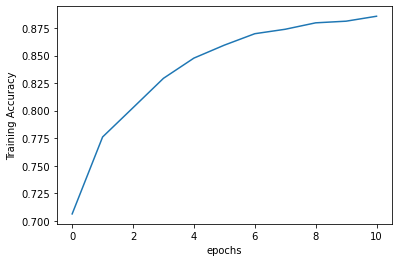

In [124]:
# visualization oof the accuracy curve over the epochs
plt.plot(model_1_hist.history["accuracy"])
plt.xlabel("epochs")
plt.ylabel("Training Accuracy")

Across epochs, we can see an increase in training accuracy, with the highest achieved being 88.25%.

### Evaluating the Model on Test Data

In [125]:
model_1.evaluate(test_Xle, test_yle)

309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8921 - loss: 0.2417


[0.24258197844028473, 0.8917332887649536]

When evaluating the model, a high testing accuracy of 89.17% was achieved using the simple model and a reasonably low loss value of 0.24 was attained.

## New Model Attempt 

In [126]:
# ### OLIVIA LEFT OFF HERE ###
# ###Want to add a soft max layer###

# # setting a seed for reproducability 
# tf.random.set_seed(555)

# # Creating the model
# model_1 = tf.keras.Sequential([
#     # defining hidden layer
#     layers.Dense(10, activation = 'relu', kernel_initializer = "he_normal", input_shape = (train_Xle.shape[1],)), 
    
#     # dropout layer 
#     layers.Dropout(0.2),
    
#     # output layer; binary so 2 neurons since 'softmax' used
# #     layers.Dense(2, activation = 'softmax')
#     layers.Dense(1)
# ])

# model_1.compile(
# #     loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False), # soft layer already added
#     loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
#     optimizer = 'adam',
#     metrics = ['accuracy'] 
# )

# # Fitting the model
# model_1_hist = model_1.fit(train_Xle, train_yle, epochs = 11, batch_size = 32)

Epoch 1/11
628/628 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6151 - loss: 0.6647
Epoch 2/11
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7654 - loss: 0.4614
Epoch 3/11
513/628 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7966 - loss: 0.4266

KeyboardInterrupt: 

### Plotting Training Accuracy

In [ ]:
# visualization oof the accuracy curve over the epochs
plt.plot(model_2_hist.history["accuracy"])
plt.xlabel("epochs")
plt.ylabel("Training Accuracy")

## Prepare data for Other Machine Learning Models

## Random Forest

## Support Vector Machines

## Logistic Regression

## Classification Discussion

# Clustering

## Data Processing

## K Means Clustering